In [ ]:
import input_data

In [ ]:
#coding:utf-8
"""
python 3
sklearn 0.18
"""
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
import input_data
import numpy as np
import pickle
import datetime

start_time = datetime.datetime.now()
mnist = input_data.read_data_sets('mnist/',one_hot=False)
x = mnist.train.images
y = mnist.train.labels

#采用交叉验证
train_data,validation_data,train_labels,validation_labels = train_test_split(x,y,test_size=0.2)
#训练一个LogisticRegression分类器

clf = LogisticRegression(penalty='l2',tol=0.001)
clf.fit(train_data,train_labels)
predictions = []
for i in range(1000):
    if i % 100 == 0:
        print('======>>>>>>','epoch:',int(i/100))
    #将预测的结果存入prediction
    output = clf.predict([mnist.test.images[i]])
    predictions.append(output)
#混淆矩阵
print(confusion_matrix(mnist.test.labels[0:1000],predictions))
#classification_report
print(classification_report(mnist.test.labels[0:1000],np.array(predictions)))
print('test accuracy is:',accuracy_score(mnist.test.labels[0:1000],predictions))
with open('logistic.pickle','wb') as f:
    pickle.dump(clf,f)
end_time = datetime.datetime.now()
print('total time is :',(end_time - start_time).seconds)

In [ ]:
# encoding: utf-8
"""
@author: monitor1379 
@contact: yy4f5da2@hotmail.com
@site: www.monitor1379.com

@version: 1.0
@license: Apache Licence
@file: mnist_decoder.py
@time: 2016/8/16 20:03

对MNIST手写数字数据文件转换为bmp图片文件格式。
数据集下载地址为http://yann.lecun.com/exdb/mnist。
相关格式转换见官网以及代码注释。

========================
关于IDX文件格式的解析规则：
========================
THE IDX FILE FORMAT

the IDX file format is a simple format for vectors and multidimensional matrices of various numerical types.
The basic format is

magic number
size in dimension 0
size in dimension 1
size in dimension 2
.....
size in dimension N
data

The magic number is an integer (MSB first). The first 2 bytes are always 0.

The third byte codes the type of the data:
0x08: unsigned byte
0x09: signed byte
0x0B: short (2 bytes)
0x0C: int (4 bytes)
0x0D: float (4 bytes)
0x0E: double (8 bytes)

The 4-th byte codes the number of dimensions of the vector/matrix: 1 for vectors, 2 for matrices....

The sizes in each dimension are 4-byte integers (MSB first, high endian, like in most non-Intel processors).

The data is stored like in a C array, i.e. the index in the last dimension changes the fastest.
"""

import numpy as np
import struct
import matplotlib.pyplot as plt

# 训练集文件
train_images_idx3_ubyte_file = '/mnt/hgfs/ubuntu14/dataset/mnist/train-images.idx3-ubyte'
# 训练集标签文件
train_labels_idx1_ubyte_file = '/mnt/hgfs/ubuntu14/dataset/mnist/train-labels.idx1-ubyte'

# 测试集文件
test_images_idx3_ubyte_file = '/mnt/hgfs/ubuntu14/dataset/mnist/t10k-images.idx3-ubyte'
# 测试集标签文件
test_labels_idx1_ubyte_file = '/mnt/hgfs/ubuntu14/dataset/mnist/t10k-labels.idx1-ubyte'


def decode_idx3_ubyte(idx3_ubyte_file):
    """
    解析idx3文件的通用函数
    :param idx3_ubyte_file: idx3文件路径
    :return: 数据集
    """
    # 读取二进制数据
    bin_data = open(idx3_ubyte_file, 'rb').read()

    # 解析文件头信息，依次为魔数、图片数量、每张图片高、每张图片宽
    offset = 0
    fmt_header = '>iiii'
    magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, offset)
    print '魔数:%d, 图片数量: %d张, 图片大小: %d*%d' % (magic_number, num_images, num_rows, num_cols)

    # 解析数据集
    image_size = num_rows * num_cols
    offset += struct.calcsize(fmt_header)
    fmt_image = '>' + str(image_size) + 'B'
    images = np.empty((num_images, num_rows, num_cols))
    for i in range(num_images):
        if (i + 1) % 10000 == 0:
            print '已解析 %d' % (i + 1) + '张'
        images[i] = np.array(struct.unpack_from(fmt_image, bin_data, offset)).reshape((num_rows, num_cols))
        offset += struct.calcsize(fmt_image)
    return images


def decode_idx1_ubyte(idx1_ubyte_file):
    """
    解析idx1文件的通用函数
    :param idx1_ubyte_file: idx1文件路径
    :return: 数据集
    """
    # 读取二进制数据
    bin_data = open(idx1_ubyte_file, 'rb').read()

    # 解析文件头信息，依次为魔数和标签数
    offset = 0
    fmt_header = '>ii'
    magic_number, num_images = struct.unpack_from(fmt_header, bin_data, offset)
    print '魔数:%d, 图片数量: %d张' % (magic_number, num_images)

    # 解析数据集
    offset += struct.calcsize(fmt_header)
    fmt_image = '>B'
    labels = np.empty(num_images)
    for i in range(num_images):
        if (i + 1) % 10000 == 0:
            print '已解析 %d' % (i + 1) + '张'
        labels[i] = struct.unpack_from(fmt_image, bin_data, offset)[0]
        offset += struct.calcsize(fmt_image)
    return labels


def load_train_images(idx_ubyte_file=train_images_idx3_ubyte_file):
    """
    TRAINING SET IMAGE FILE (train-images-idx3-ubyte):
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000803(2051) magic number
    0004     32 bit integer  60000            number of images
    0008     32 bit integer  28               number of rows
    0012     32 bit integer  28               number of columns
    0016     unsigned byte   ??               pixel
    0017     unsigned byte   ??               pixel
    ........
    xxxx     unsigned byte   ??               pixel
    Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black).

    :param idx_ubyte_file: idx文件路径
    :return: n*row*col维np.array对象，n为图片数量
    """
    return decode_idx3_ubyte(idx_ubyte_file)


def load_train_labels(idx_ubyte_file=train_labels_idx1_ubyte_file):
    """
    TRAINING SET LABEL FILE (train-labels-idx1-ubyte):
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    0004     32 bit integer  60000            number of items
    0008     unsigned byte   ??               label
    0009     unsigned byte   ??               label
    ........
    xxxx     unsigned byte   ??               label
    The labels values are 0 to 9.

    :param idx_ubyte_file: idx文件路径
    :return: n*1维np.array对象，n为图片数量
    """
    return decode_idx1_ubyte(idx_ubyte_file)


def load_test_images(idx_ubyte_file=test_images_idx3_ubyte_file):
    """
    TEST SET IMAGE FILE (t10k-images-idx3-ubyte):
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000803(2051) magic number
    0004     32 bit integer  10000            number of images
    0008     32 bit integer  28               number of rows
    0012     32 bit integer  28               number of columns
    0016     unsigned byte   ??               pixel
    0017     unsigned byte   ??               pixel
    ........
    xxxx     unsigned byte   ??               pixel
    Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black).

    :param idx_ubyte_file: idx文件路径
    :return: n*row*col维np.array对象，n为图片数量
    """
    return decode_idx3_ubyte(idx_ubyte_file)


def load_test_labels(idx_ubyte_file=test_labels_idx1_ubyte_file):
    """
    TEST SET LABEL FILE (t10k-labels-idx1-ubyte):
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    0004     32 bit integer  10000            number of items
    0008     unsigned byte   ??               label
    0009     unsigned byte   ??               label
    ........
    xxxx     unsigned byte   ??               label
    The labels values are 0 to 9.

    :param idx_ubyte_file: idx文件路径
    :return: n*1维np.array对象，n为图片数量
    """
    return decode_idx1_ubyte(idx_ubyte_file)




def run():
    train_images = load_train_images()
    train_labels = load_train_labels()
    # test_images = load_test_images()
    # test_labels = load_test_labels()

    # 查看前十个数据及其标签以读取是否正确
    for i in range(10):
        print train_labels[i]
        plt.imshow(train_images[i], cmap='gray')
        plt.show()
    print 'done'

if __name__ == '__main__':
    run()


In [1]:
from input_mnist_data import read_all_data

root_path = "/mnt/hgfs/ubuntu14/dataset/mnist"
train_images,train_labels,test_images,test_labels = read_all_data(root_path)

print train_images.shape

extract train images
extract train labels
extract test images
extract test labels
Done
(60000, 28, 28)


In [51]:
import csv
import numpy as np
data_path = "/mnt/hgfs/ubuntu14/dataset/iris/iris.csv"
classify = ["Iris-setosa","Iris-versicolor","Iris-virginica"]

data = np.zeros(shape=[150,4])
label = np.zeros(shape=[150,])
with open(data_path,"r") as f:
    reader = csv.reader(f)
    for i,row in enumerate(reader):
        if row:
            data[i] = np.array(row[:-1])
            label[i] = classify.index(row[-1])

from sklearn.cluster import KMeans
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=10)
kmeans.fit(data)

print kmeans.labels_
print kmeans.cluster_centers_
print kmeans.inertia_

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 2 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0]
[[ 5.9016129   2.7483871   4.39354839  1.43387097]
 [ 5.006       3.418       1.464       0.244     ]
 [ 6.85        3.07368421  5.74210526  2.07105263]]
78.9408414261


In [6]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
digits = load_digits()
data = digits.data

print data

[[  0.   0.   5. ...,   0.   0.   0.]
 [  0.   0.   0. ...,  10.   0.   0.]
 [  0.   0.   0. ...,  16.   9.   0.]
 ..., 
 [  0.   0.   1. ...,   6.   0.   0.]
 [  0.   0.   2. ...,  12.   0.   0.]
 [  0.   0.  10. ...,  12.   1.   0.]]


Automatically created module for IPython interactive environment


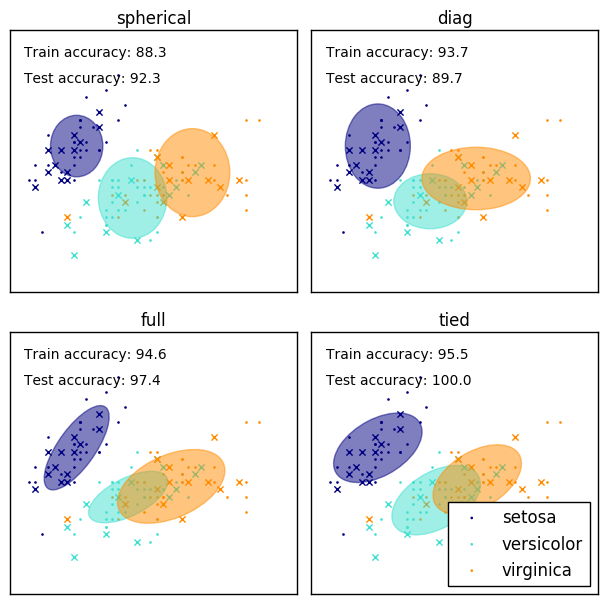

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

print(__doc__)

colors = ['navy', 'turquoise', 'darkorange']


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = dict((cov_type, GaussianMixture(n_components=n_classes,
                   covariance_type=cov_type, max_iter=20, random_state=0))
                  for cov_type in ['spherical', 'diag', 'tied', 'full'])

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=iris.target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))


plt.show()